In [121]:
import time
import pandas as pd
import numpy as np

from scipy.optimize import differential_evolution

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler, Normalizer, PowerTransformer, RobustScaler, StandardScaler, PolynomialFeatures
from sklearn.metrics import max_error, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, median_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

In [122]:
class GRNN(BaseEstimator, RegressorMixin):
    def __init__(self, name = 'GRNN', sigma = 0.1):
        self.name = name
        self.sigma = 2 * np.power(sigma, 2)

    def predict(self, instance_X, X_train, Y_train):
        gausian_distances = np.exp(-np.power(np.sqrt((np.square(X_train-instance_X).sum(axis=1))),2) / self.sigma)
        gausian_distances_sum = gausian_distances.sum()
        gausian_distances_sum = max(gausian_distances_sum, 1e-07)
        return np.multiply(gausian_distances, Y_train).sum() / gausian_distances_sum

In [123]:
# Load all data with pandas
data = pd.read_csv('/content/Dataset_2_final.txt', sep='\t')
data_columns = data.columns
data

,_,drift 1 [%),drift 2 [%],drift 3 [%],failed strands within Zone 1,failed strands within Zone 2,failed strands within Zone 3
0,10,-0.068549,-0.028462,0.025043,16,0,0
1,10,-0.068910,-0.052050,-0.029855,16,16,0
2,10,-0.074083,-0.059339,-0.060759,16,16,16
3,10,-0.104921,-0.080052,-0.058953,28,12,4
4,10,-0.108999,-0.103969,-0.110403,28,24,16
...,...,...,...,...,...,...,...
81,18,-0.075189,-0.085839,-0.096963,36,28,8
82,22,-0.281796,-0.351556,-0.411563,60,48,24
83,30,-0.175737,-0.178943,-0.197909,60,36,12
84,17,-0.147493,-0.129396,-0.134660,48,32,16


In [124]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   _                             86 non-null     int64  
 1   drift 1 [%)                   86 non-null     float64
 2   drift 2 [%]                   86 non-null     float64
 3   drift 3 [%]                   86 non-null     float64
 4   failed strands within Zone 1  86 non-null     int64  
 5   failed strands within Zone 2  86 non-null     int64  
 6   failed strands within Zone 3  86 non-null     int64  
dtypes: float64(3), int64(4)
memory usage: 4.8 KB


In [125]:
X = data.iloc[:,:4]
Y = data.iloc[:,4:]

X_train = X[5:]
X_test = X[:5]

Y_train = Y[5:]
Y_test = Y[:5]

Y_train = Y_train.to_numpy()
Y_test = Y_test.to_numpy()

# Transform data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [126]:
# # Load all data with pandas
# data = pd.read_csv('/content/Tunneling_Induced_building_damage_dataset.txt', sep='\t')
# data = data.drop(labels = 'Tot No. Simulations', axis=1)
# data_columns = data.columns
# data.head()

# X = data.iloc[:,:15]
# Y = data.iloc[:,15:]
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=42)
# Y_train = Y_train.to_numpy()
# Y_test = Y_test.to_numpy()

# # Transform data
# scaler = MinMaxScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

In [127]:
results = {}
# cost function to optimize
def calculate_error_cost(sigma, error_function, X_train, Y_train, X_test, Y_test):
    grnn = GRNN(sigma=sigma[0])
    predictions = np.array([grnn.predict(i, X_train, Y_train) for i in X_test])
    return -error_function(Y_test, predictions)

grnn_sigmas_1 = []
train_predictions = []
test_predictions = []

for i, (y_train, y_test) in enumerate(zip(Y_train[:].T, Y_test[:].T)):
    start_time = time.time()

    # Train GRNN
    print(f'Training: {data_columns[4+i]}')
    sigma = differential_evolution(
        calculate_error_cost,
        bounds=[(0.001, 10)],
        args=(r2_score, X_train, y_train, X_test, y_test)
    )['x'][0]
    grnn = GRNN(sigma=sigma)

    train_pred = np.apply_along_axis(
        lambda x : grnn.predict(x, X_train, y_train),
        axis=1,
        arr=X_train
    )

    test_pred = np.apply_along_axis(
        lambda x : grnn.predict(x, X_train, y_train),
        axis=1,
        arr=X_test
    )

    train_predictions.append(train_pred)
    test_predictions.append(test_pred)
    grnn_sigmas_1.append(sigma)

    MaxError = max_error                    (y_test, test_pred)
    MAE = mean_absolute_error               (y_test, test_pred)
    MSE = mean_squared_error                (y_test, test_pred)
    MedError = median_absolute_error        (y_test, test_pred)
    RMSE = mean_squared_error               (y_test, test_pred, squared=False)
    MAPE = mean_absolute_percentage_error   (y_test, test_pred)
    R2 = r2_score                           (y_test, test_pred)

    results.update({
      f'{data_columns[4+i]}':
          {
              'time': time.time() - start_time,
              'sigma': sigma,
              # 'y_true': Y_test[:,i].ravel(),
              # 'y_pred': predictions,
              'MaxError' : MaxError,
              'MAE' : MAE,
              'MSE' : MSE,
              'MedError' : MedError,
              'RMSE' : RMSE,
              'MAPE' : MAPE,
              'R2' : R2
          }
    })

exp_result = pd.DataFrame(results)
exp_result.to_excel(f'R2_MinMaxScaler.xlsx')

Training: failed strands within Zone 1
Training: failed strands within Zone 2
Training: failed strands within Zone 3


In [128]:
train_y_grnn = np.stack(train_predictions, axis=1)
test_y_grnn = np.stack(test_predictions, axis=1)

train_pca_input = np.concatenate((X_train, train_y_grnn), axis=1)
test_pca_input = np.concatenate((X_test, test_y_grnn), axis=1)

print(train_y_grnn.shape)
print(X_train.shape)
print(train_pca_input.shape)

(81, 3)
(81, 4)
(81, 7)


In [129]:
pca = PCA()
train_pca = pca.fit_transform(train_pca_input)
test_pca = pca.transform(test_pca_input)

#explained_variance = pca.explained_variance_ratio_
print (train_pca.shape)

(81, 7)


In [130]:
results = {}
# cost function to optimize
def calculate_error_cost(sigma, error_function, X_train, Y_train, X_test, Y_test):
    grnn = GRNN(sigma=sigma[0])
    predictions = np.array([grnn.predict(i, X_train, Y_train) for i in X_test])
    # USE MSE
    return -error_function(Y_test, predictions)

grnn_sigmas_2 = []
predictions = []
for i, (y_train, y_test) in enumerate(zip(Y_train[:].T, Y_test[:].T)):
    start_time = time.time()

    print(f'Training: {data_columns[4+i]}')
    sigma = differential_evolution(
        calculate_error_cost,
        bounds=[(0.001, 10)],
        args=(r2_score, train_pca, y_train, test_pca, y_test)
    )['x'][0]
    grnn = GRNN(sigma=sigma)
    pred = np.apply_along_axis(
        lambda x : grnn.predict(x, train_pca, y_train),
        axis=1,
        arr=test_pca
    )

    MaxError = max_error                    (y_test, pred)
    MAE = mean_absolute_error               (y_test, pred)
    MSE = mean_squared_error                (y_test, pred)
    MedError = median_absolute_error        (y_test, pred)
    RMSE = mean_squared_error               (y_test, pred, squared=False)
    MAPE = mean_absolute_percentage_error   (y_test, pred)
    R2 = r2_score                           (y_test, pred)

    predictions.append(pred)
    grnn_sigmas_2.append(sigma)

    results.update({
        f'{data_columns[4+i]}':
              {
                  'time': time.time() - start_time,
                  'sigma': sigma,
                  # 'y_true': Y_test[:,i].ravel(),
                  # 'y_pred': predictions,
                  'MaxError' : MaxError,
                  'MAE' : MAE,
                  'MSE' : MSE,
                  'MedError' : MedError,
                  'RMSE' : RMSE,
                  'MAPE' : MAPE,
                  'R2' : R2
              }
      })


exp_result = pd.DataFrame(results)
exp_result.to_excel(f'PCA_R2_MinMaxScaler.xlsx')

Training: failed strands within Zone 1
Training: failed strands within Zone 2
Training: failed strands within Zone 3


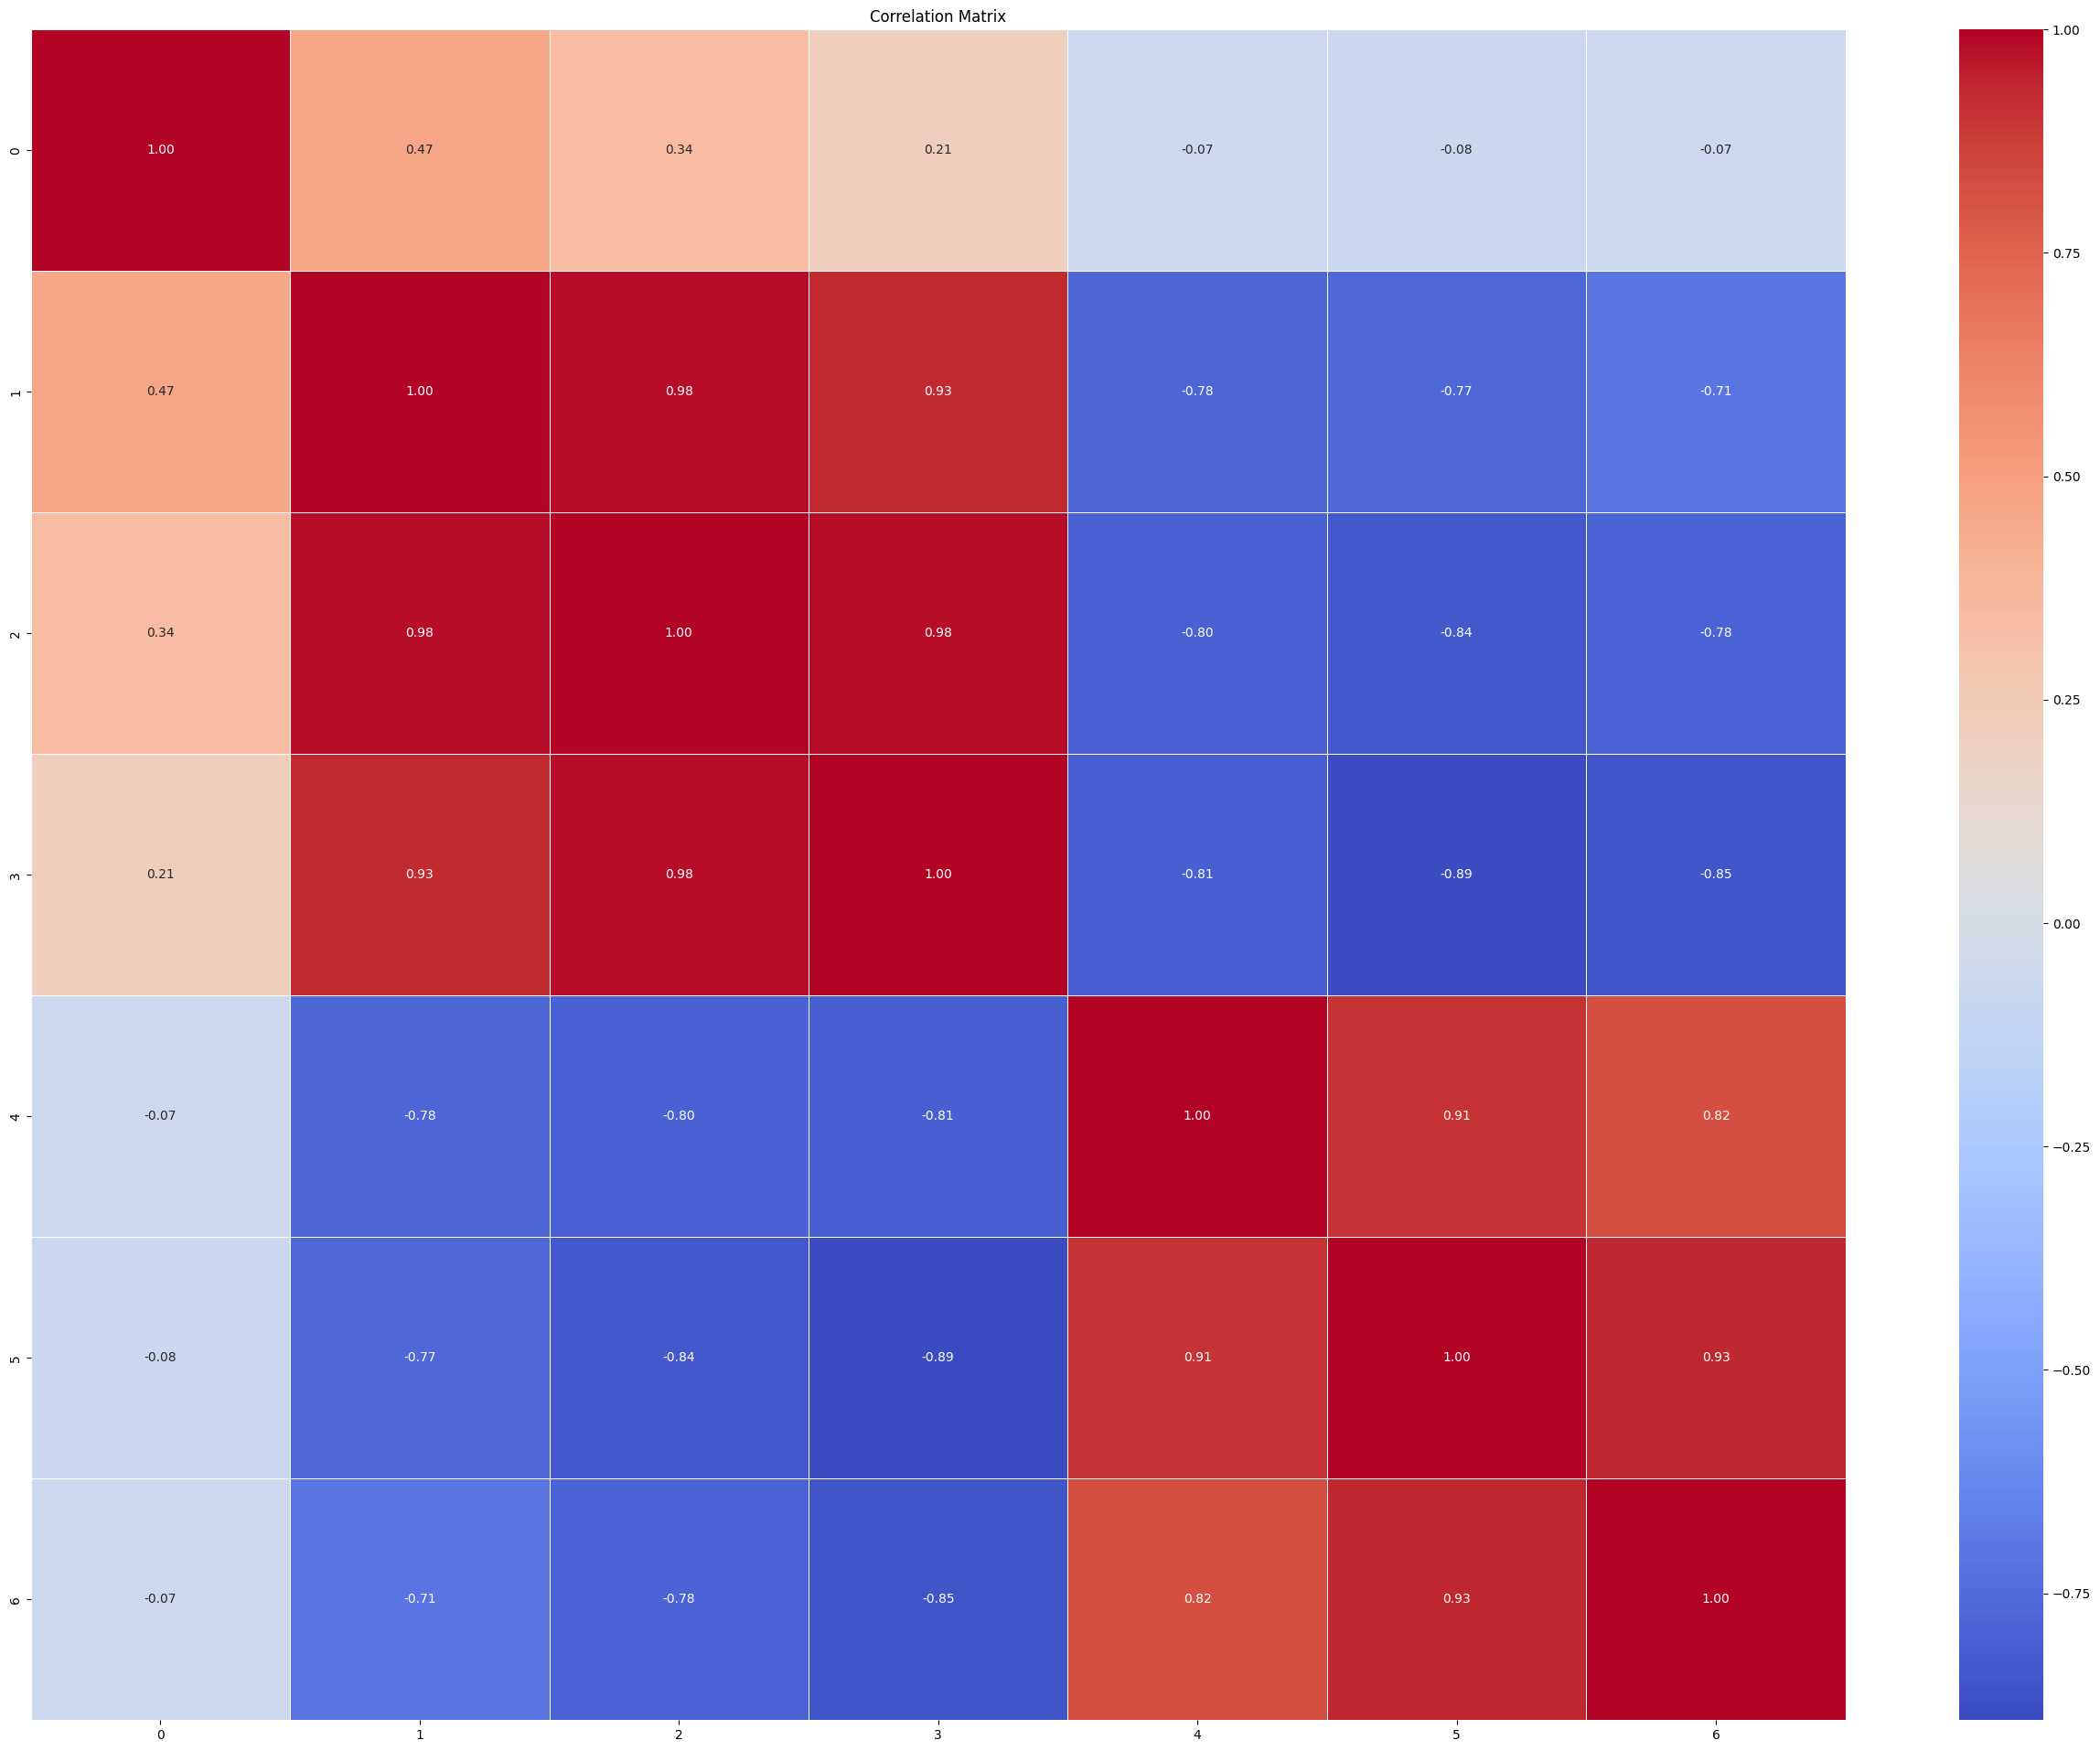

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame
df = pd.DataFrame(train_pca_input)

# Calculate correlation matrix
corr_matrix = df.corr()

# Plot correlation matrix using seaborn
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

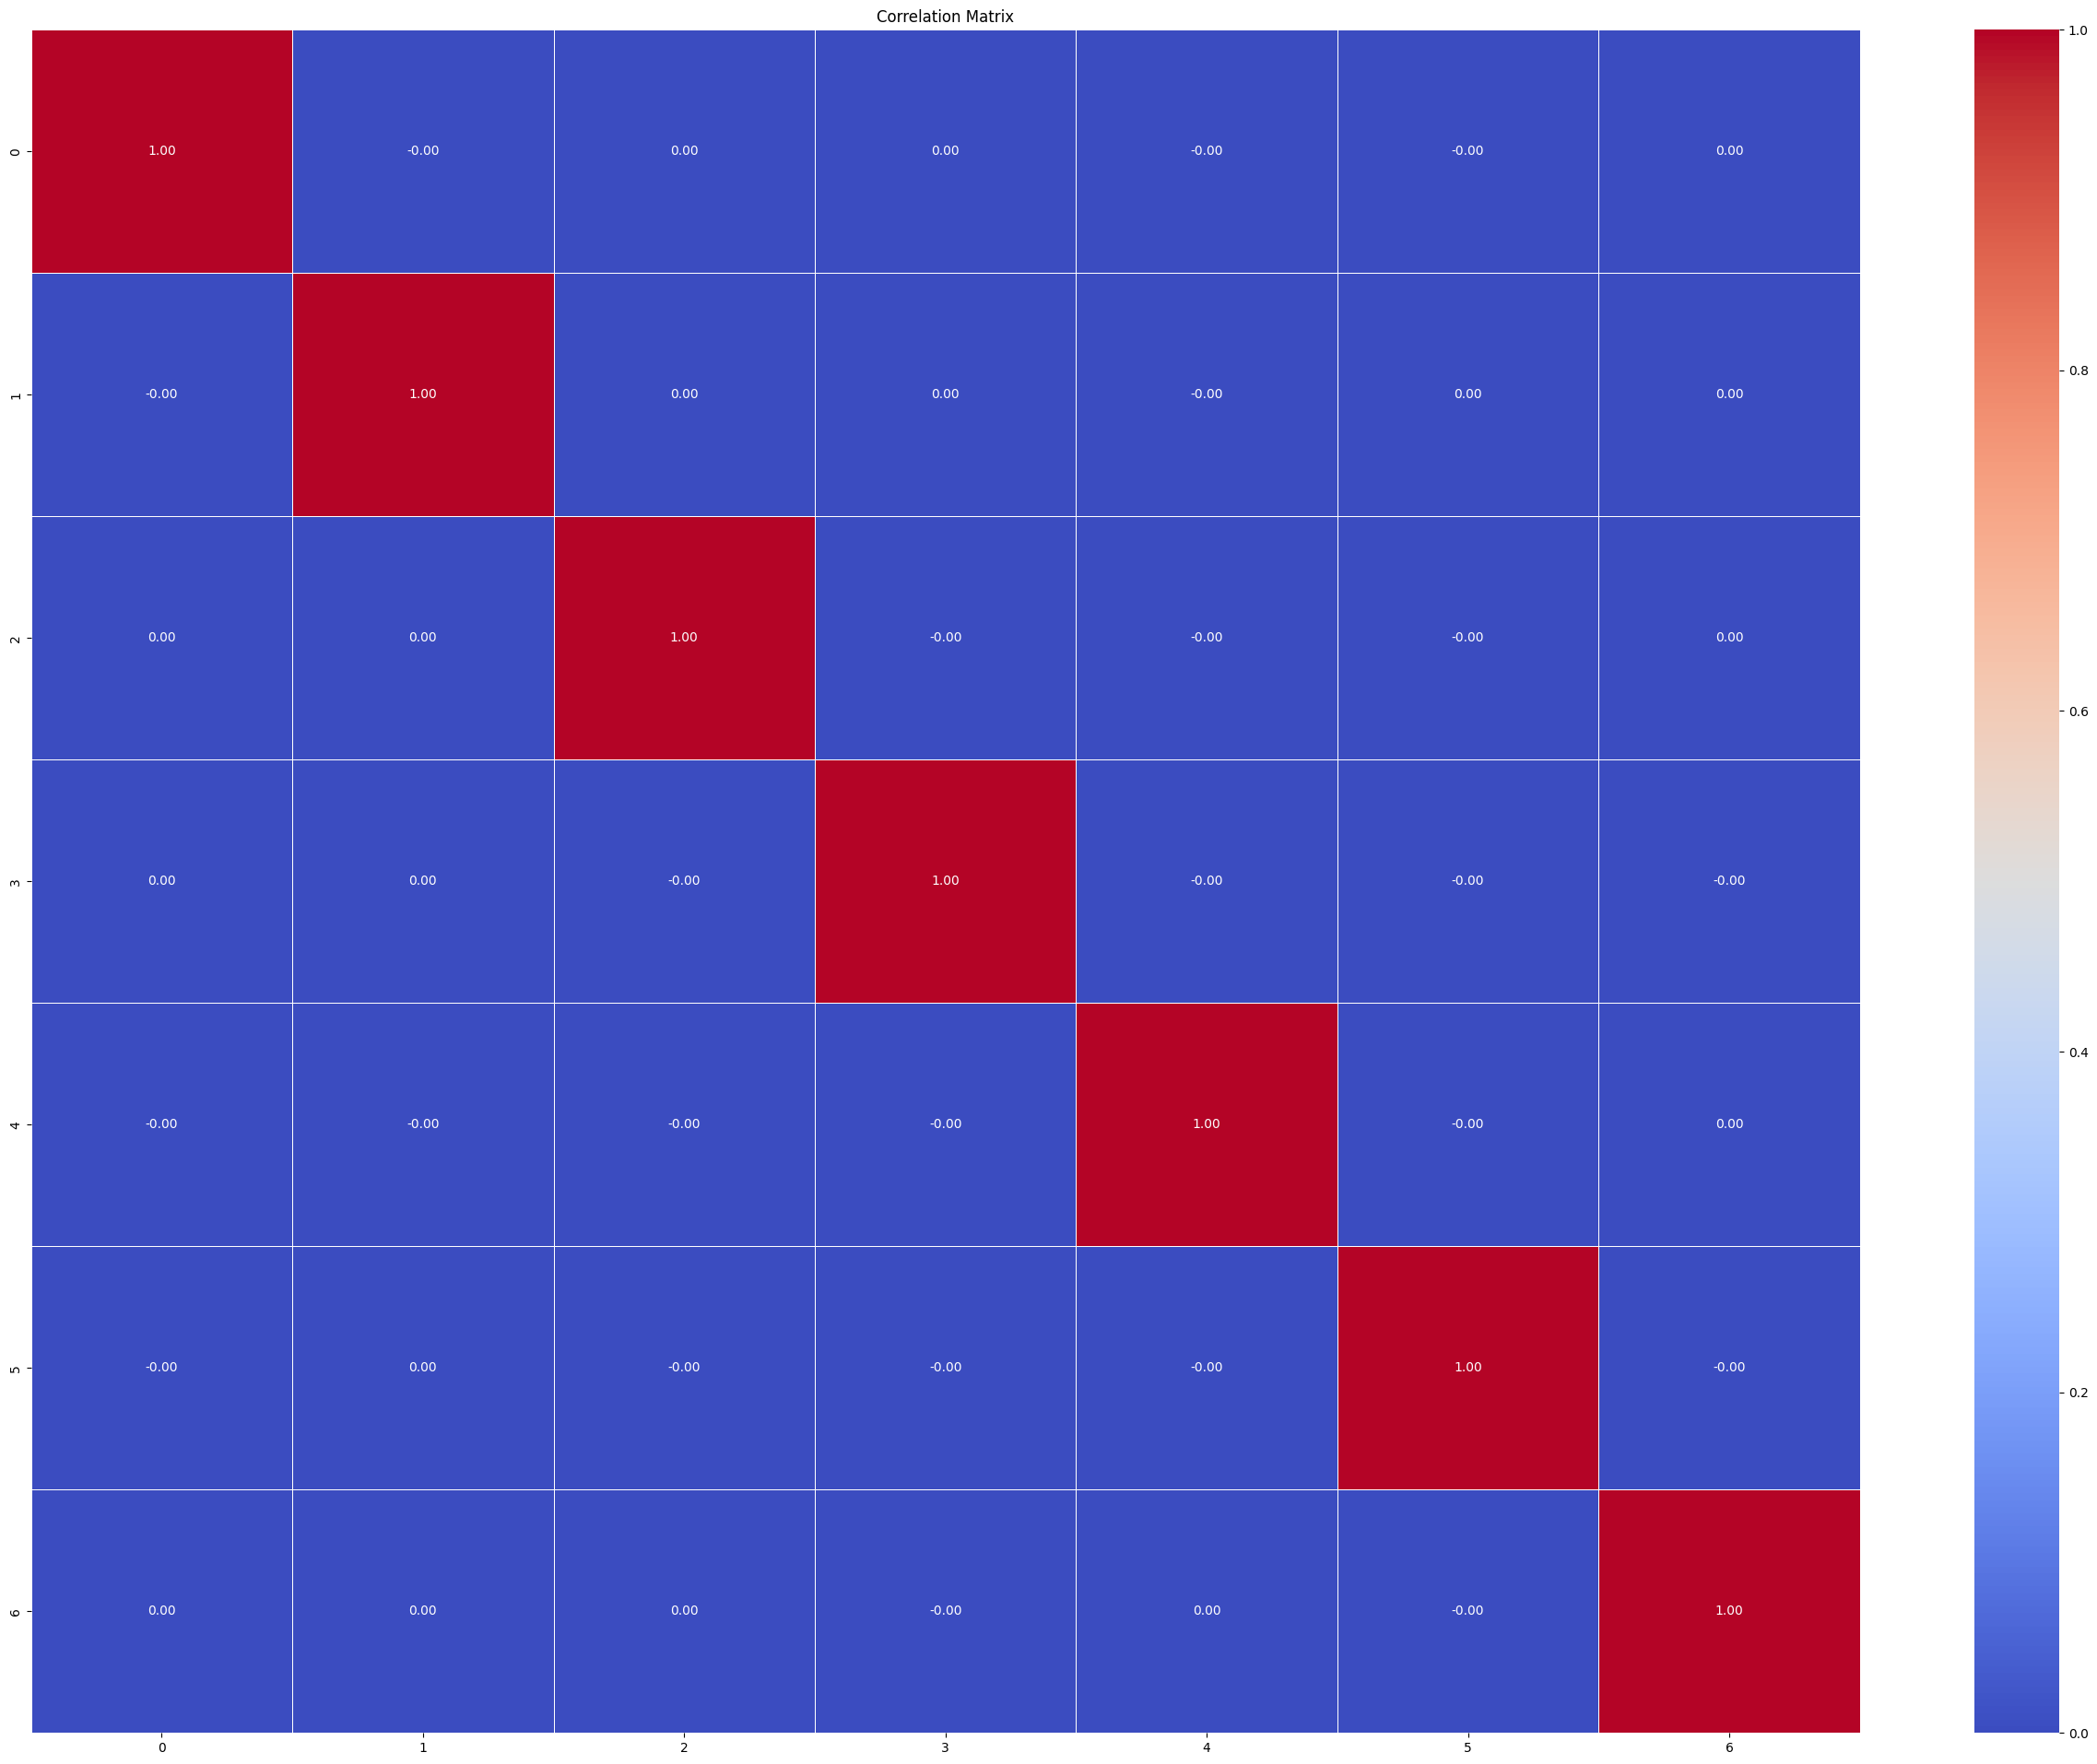

In [132]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sample DataFrame
df = pd.DataFrame(train_pca)

# Calculate correlation matrix
corr_matrix = df.corr()

# Plot correlation matrix using seaborn
plt.figure(figsize=(32, 24))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

In [133]:
train_pca.shape

(81, 7)